<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - UC3
Crop type feature engineering

In [1]:
import openeo
from openeo.processes import ProcessBuilder, array_modify, quantiles, sd, array_concat
from eo_utils import *
from shapely.geometry import box
import pandas as pd
from helper import *
import hvplot.xarray
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
import urllib.request

## Objectives and approach

The goal of this section is to show how openEO functionality can be integrated into a basic feature engineering pipeline. We will do this using crop classification as an example.

The constantly increasing demand of food has resulted in a highly intensified agricultural production. This intensification on the one hand requires more planning and management, and on the other, threatens ecosystem services that need to be monitored by scientists and decision makers who rely on detailed spatial information of crop cover in agricultural areas.

Crop classification on a large scale is a challenging task, but with the recent advances in satellite sensor technology and the push of a.o. the ESA for higher resolution open satellite data with a frequent revisit time this task has become possible.

There are various approaches to crop classification. One can use basic rule-based classification as shown in the rule-based notebook, or use more sophisticated methods such as one of various machine learning models. In this example, we will have a look at this machine learning approach and more specifically, look at implementing a random forest model.

Generally, any classification task will contain the following steps:

* Preprocessing & feature engineering
* Training
* Classification & model evaluation

We will have a more detailed look at all three of these steps, and provide code examples along the way.

First, make a connection:

In [2]:
connection = openeo.connect("openeo.vito.be")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.vito.be/openeo/1.1/' with OidcBearerAuth>

Next, we'll set some variables we will need later on.

In [4]:
year = 2020
temp_ext_s2 = [str(year-1)+"-09-01", str(year+1)+"-04-30"]
temp_ext_s1 = [str(year)+"-01-01",str(year)+"-12-31"]
temp_ext_wc = str(year)

job_options = {
        "driver-memory": "2G",
        "driver-memoryOverhead": "1G",
        "driver-cores": "2",
        "executor-memory": "2G",
        "executor-memoryOverhead": "2G",
        "executor-cores": "1",
        "max-executors": "100"
}

## Load the dataset

Connect to the vito backend and load a large number of S2 bands (they will be used to calculate a variety of vegetation indices) and the scene classification layer (SCL) for the year of 2020.
We will use the scene classification band to perform cloud masking and subsequently drop the SCL layer as we will not need it anymore in the rest of this notebook.

We use a temporal range that is slightly bigger than the actual temporal range we need to improve the interpolation that we will do later on. For the S1 imagery, no interpolation is needed as no cloud masking needs to be performed, hence the temporal extent is kept to the range we need to avoid loading in unnecessary data.

In [5]:
s2 = connection.load_collection("TERRASCOPE_S2_TOC_V2",
                                temporal_extent=temp_ext_s2,
                                bands=["B03","B04","B05","B06","B07","B08","B11","B12","SCL"])
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL").filter_bands(s2.metadata.band_names[:-1])

In [8]:
s1 = connection.load_collection("S1_GRD_SIGMA0_ASCENDING",
                                temporal_extent=temp_ext_s1,
                                bands=["VH","VV"]
                               )
s1 = s1.apply_dimension(dimension="bands",process=lambda x: array_modify(data=x, values=x.array_element(0)/x.array_element(1), index=0))
s1 = s1.rename_labels("bands", ["ratio"] + s1.metadata.band_names)
#TODO: this scaling does not seem appropriate for sentinel-1
s1 = s1.apply(process=lambda x: x.linear_scale_range(0,1,0,250))

In addition, we want to load in a crop mask to ensure that we only classify areas that are actually cropland.

In [ ]:
cropland_mask = connection.load_collection("ESA_WORLDCOVER_10M_2020_V1",
                                temporal_extent=temp_ext_wc,
                                bands=["MAP"]
                    )
cropland_mask = cropland_mask.band("MAP") != 40

s2 = s2.mask(cropland_mask.max_time().resample_cube_spatial(s2))
s1 = s1.mask(cropland_mask.max_time().resample_cube_spatial(s1))

bbox = {"west": 5.14, "south": 51.17, "east": 5.15, "north": 51.18}
s2 = s2.filter_bbox(bbox)
s1 = s1.filter_bbox(bbox)
s2.download("data/test/s2.nc")
s1.download("data/test/s1.nc")


## Feature selection for crop type mapping

For this use case, the following crop types will be mapped:

* Wheat
* Maize 
* Potato 
* Sugar beet
* Soy

A separability analysis was conducted based on the reference data currently available in the WorldCereal Common Input Baseline. We only focused on European reference data (i.e. LPIS and SIGPAC data). All classification features currently supported by the WorldCereal system were tested. Separability was first computed for each crop type separately in a binary one-vs-all case. Afterwards, an average separability of each feature was computed and features were ranked accordingly. Based on the ranking of features for individual crop types, the overall ranking for all types and ease of implementation, a proposal is made of features to be included for the openEO CCN.

**Sentinel-2 features**
For the final feature selection, the following timeseries should be computed/derived (see satio.rsindices for definitions of the band combinations mentioned below) from Sentinel-2:
* bands B06 and B12
* vegetation indices NDVI, NDMI, NDGI, ANIR, NDRE1, NDRE2 and NDRE5

**Sentinel-1 features**
* bands VV and VH
* VH/VV ratio

Based on all these timeseries, the following features should be computed: 
* Percentiles (p10, p50, p90) 
* Standard deviation 
* Tsteps. This results in a set of 6 features. Ts0, ts1, ts2, ts3, ts4 and ts5, of which ts0, ts1 and ts5 are the most important ones. The others can be dropped to limit the total number of features to be used. 

**Other features**
* Altitude derived from Copernicus 30m DEM
* Derived from AgERA5 meteo data: Sum of precipitation over growing season
* P10, p50 and p90 of mean temperature 

In the end, we decided to stick with the Sentinel-1 and Sentinel-2 features (percentiles, std. dev. and t-steps), and leave the other features out for now as the accuracy was already very decent. With that we got to an accuracy of about 97% on the test set, but bear in mind that the test set was made up of samples from fields known to be one of the 5 crop types, and not any other crop classes / land cover classes.

## Feature computation

Features are generally computed over the temporal dimension, and result in multiple bands being added. In the openEO API, the 'apply_dimension' process allows us to work on the temporal dimension, and store the result in the bands dimension.

We calculate a number of vegetation indices, aggregate to 10-day composites, interpolate linearly to fill up any potential missing data values and crop back to the the final temporal range (01-01-2020 to 31-12-2020). Finally, we merge all the cubes.

In [8]:
idx_list = ["NDVI","NDMI","NDGI","ANIR","NDRE1","NDRE2","NDRE5"]
s2_list = ["B06","B12"]

s1_dekad = s1.aggregate_temporal_period(period="dekad", reducer="mean")
s1_dekad = s1_dekad.apply_dimension(dimension="t", process="array_interpolate_linear")
#s1_dekad = s1_dekad.resample_cube_spatial(s2)

indices = compute_indices(s2, idx_list).filter_bands(s2_list+idx_list)
idx_dekad = indices.aggregate_temporal_period(period="dekad", reducer="mean")
idx_dekad = idx_dekad.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year)+"-12-31"])

base_features = idx_dekad.merge_cubes(s1_dekad)
base_features = base_features.rename_labels("bands",s2_list+idx_list+["ratio","VV","VH"])

From these temporal cubes we will calculate the features that we need: quantiles, standard deviation and t-steps of all indices and band 6 and 12. We use linear scaling to ensure that all values are int8s for the sake of computational efficiency.

In [9]:
def computeStats(input_timeseries:ProcessBuilder):
    tsteps = list([input_timeseries.array_element(6*index) for index in range(0,6)])
    return array_concat(array_concat(input_timeseries.quantiles(probabilities=[0.1,0.5,0.9]),input_timeseries.sd()),tsteps)

features = base_features.apply_dimension(dimension='t',target_dimension='bands', process=computeStats).apply(lambda x: x.linear_scale_range(0,250,0,250))

tstep_labels = [ "t"+ str(6*index) for index in range(0,6) ]
all_bands = [band + "_" + stat for band in base_features.metadata.band_names for stat in ["p10","p50","p90","sd"] + tstep_labels ]
features = features.rename_labels('bands',all_bands)

## Dataset sampling

Once we have our features defined, we will want to generate a set of input features for model calibration. Instead of calculating features
for a very large area, openEO can sample the datacube at selected locations.

Sampling a datacube in openEO currently requires polygons as sampling features. Other types of geometry, like lines
and points, should be converted into polygons first by applying a buffering operation. Using the spatial resolution
of the datacube as buffer size can be a way to approximate sampling at a point.

To indicate to openEO that we only want to compute the datacube for certain polygon features, we use the
`~openeo.rest.datacube.DataCube.filter_spatial` method.

Next to that, we will also indicate that we want to write multiple output files. This is more convenient, as we will
want to have one or more raster outputs per sampling feature, for convenient further processing. To do this, we set
the 'sample_by_feature' output format property, which is available for the netCDF and GTiff output formats.

Sampling only works for batch jobs, because it results in multiple output files, which can not be conveniently transferred
in a synchronous call.

Combining all of this, results in the following sample code:




In [10]:
#crops = {"maize":1200,"potatos":5100,"sugarbeet":8100,"barley":1500,"soy":4100}
crops = ["maize", "potatos", "sugarbeet", "barley", "soy"]
crop_samples = {name:gpd.read_file("UC3_resources/"+ name + "_2019.geojson", driver='GeoJSON') for name in crops}

points_per_type = point_sample_fields(crop_samples, 30)

In [11]:
for i in points_per_type.keys():
    sampled_features = features.filter_spatial(eval(points_per_type[i]))
    job = sampled_features.execute_batch(
        title="Point feature extraction",
        description="Feature extraction for p10,p50,p90,sd and tsteps",
        out_format="netCDF",
        sample_by_feature=True,
        job_options=job_options)
    results = job.get_results()
    results.download_files("./data/rf_300_"+i)

0:00:00 Job 'j-e48c09fdad8140df83ec291e32f5475d': send 'start'
0:00:28 Job 'j-e48c09fdad8140df83ec291e32f5475d': queued (progress N/A)
0:00:36 Job 'j-e48c09fdad8140df83ec291e32f5475d': queued (progress N/A)
0:00:44 Job 'j-e48c09fdad8140df83ec291e32f5475d': queued (progress N/A)
0:00:54 Job 'j-e48c09fdad8140df83ec291e32f5475d': queued (progress N/A)
0:01:07 Job 'j-e48c09fdad8140df83ec291e32f5475d': queued (progress N/A)
0:01:22 Job 'j-e48c09fdad8140df83ec291e32f5475d': queued (progress N/A)
0:01:40 Job 'j-e48c09fdad8140df83ec291e32f5475d': queued (progress N/A)
0:02:01 Job 'j-e48c09fdad8140df83ec291e32f5475d': running (progress N/A)
0:02:28 Job 'j-e48c09fdad8140df83ec291e32f5475d': running (progress N/A)
0:03:00 Job 'j-e48c09fdad8140df83ec291e32f5475d': running (progress N/A)
0:03:39 Job 'j-e48c09fdad8140df83ec291e32f5475d': running (progress N/A)
0:04:28 Job 'j-e48c09fdad8140df83ec291e32f5475d': running (progress N/A)
0:05:29 Job 'j-e48c09fdad8140df83ec291e32f5475d': error (progress N/

JobFailedException: Batch job 'j-e48c09fdad8140df83ec291e32f5475d' didn't finish successfully. Status: error (after 0:05:30).

We can then load this data into a dataframe which can be used to train the model.

In [14]:
%time df = prep_df(2020,all_bands)
df.head()

Wall time: 2min 34s


,Crop type,Iteration nr,B06_p10,B06_p50,B06_p90,B06_sd,B06_t0,B06_t6,B06_t12,B06_t18,...,VH_p10,VH_p50,VH_p90,VH_sd,VH_t0,VH_t6,VH_t12,VH_t18,VH_t24,VH_t30
0,barley,openEO_0,46.889999,53.099998,84.099998,12.156557,62.50,53.200001,79.5,45.0,...,13.7,26.875,52.049999,17.337147,34.0,75.5,29.0,23.0,20.25,18.75
1,barley,openEO_1,42.750000,66.777779,99.811111,20.900290,39.00,61.333332,83.0,55.0,...,9.9,22.250,69.199997,20.769791,28.0,47.5,27.5,10.0,13.00,52.00
2,barley,openEO_10,54.466667,63.472221,88.733337,12.992085,67.75,55.333332,86.0,43.0,...,12.7,29.000,50.000000,14.174424,29.0,56.0,50.0,16.0,17.00,24.00
3,barley,openEO_100,55.000000,62.000000,90.099998,13.240349,61.75,57.000000,86.0,44.0,...,8.7,32.000,84.599998,31.028559,64.0,76.0,60.0,16.0,10.00,35.00
4,barley,openEO_101,33.000000,52.000000,88.833336,19.758512,31.75,45.000000,76.5,50.0,...,10.7,25.500,60.000000,18.545933,20.0,73.0,18.0,17.0,31.00,36.00


## Training a random forest model
Next, we'll start training a model. We first split our dataset into a training and test set, and then perform grid search to find the optimal parameters for our model.

In [15]:
X = df[all_bands]
y = df["Crop type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
param_grid = {
    'max_depth': [100, None],
    'max_features': [4, 'log2'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 200, 300]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'max_depth': 100,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [17]:
gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(by=["mean_test_score"],axis=0,ascending=False)
gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,0.348849,0.003531,0.025178,0.002903,100,log2,1,3,100,"{'max_depth': 100, 'max_features': 'log2', 'mi...",0.993056,0.975694,0.968641,0.979130,0.010259,1
1,0.691314,0.003247,0.043802,0.001300,100,4,1,2,200,"{'max_depth': 100, 'max_features': 4, 'min_sam...",0.982639,0.975694,0.972125,0.976820,0.004365,2
8,0.926650,0.004729,0.060367,0.001203,100,4,2,2,300,"{'max_depth': 100, 'max_features': 4, 'min_sam...",0.989583,0.975694,0.965157,0.976812,0.010003,3
29,1.170301,0.017374,0.076794,0.002336,None,4,1,3,300,"{'max_depth': None, 'max_features': 4, 'min_sa...",0.986111,0.982639,0.961672,0.976807,0.010796,4
2,1.002288,0.026084,0.058292,0.003380,100,4,1,2,300,"{'max_depth': 100, 'max_features': 4, 'min_sam...",0.989583,0.968750,0.968641,0.975658,0.009847,5


From playing around with gridsearch we can concluse that the most important model parameters are:
* max_features: low (around 3-5)
* min_samples_leaf: low (1)
* min_samples_split: low (2)

And we can run the best model on our test set and calculate the accuracy (note that our test set consists of either one of the 5 crop types, so the results on a set consisting of other crop types or even land cover types will be lower.

In [18]:
y_pred = grid_search.predict(X_test)
print("Accuracy on test set: "+str(accuracy_score(y_test,y_pred))[0:5])

Accuracy on test set: 0.978


We can then save this model

In [79]:
filename = './data/rf_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

After saving the model, we can upload it to any public repository. The model on this repository can then be accessed from the UDF that will be used for performing inference.

We select an area for which we want to perform model inference.

In [13]:
center = [50.8, 4.75]
zoom = 13

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[50.8, 4.75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

We can then use the model to do inference and store the result

In [18]:
terrascope_settings = {
    "SENTINEL2":"TERRASCOPE_S2_TOC_V2",
    "SENTINEL1":"S1_GRD_SIGMA0_ASCENDING",
    "mask":True,
    "url":"openeo.cloud",
    "props": None
}
creo_settings = {
    "SENTINEL2":"SENTINEL2_L2A",
    "SENTINEL1":"SENTINEL1_GRD",
    "mask":False,
    "url":"openeo.creo.vito.be",
    "props": None
}

s = terrascope_settings
connection = openeo.connect(s["url"]).authenticate_oidc()
bbox = eoMap.getBbox()

udf_rf = """
from typing import Dict
from openeo_udf.api.datacube import DataCube
import pickle
import urllib.request
import xarray
import sklearn
from openeo.udf.xarraydatacube import XarrayDataCube
import functools

@functools.lru_cache(maxsize=25)
def load_model():
    return pickle.load(urllib.request.urlopen("https://artifactory.vgt.vito.be:443/auxdata-public/openeo/rf_model.pkl"))

def impute(a):
    a[np.isnan(a)] = np.int16(np.nanmean(a))
    return a

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    stacked_array = array.stack(pixel=("x","y"))
    stacked_array = stacked_array.transpose()
    stacked_array_f = stacked_array[~np.isnan(stacked_array).all(axis=1)]
    
    if len(stacked_array_f) == 0:
        result = np.full(np.multiply(*array.shape[1:]),np.nan)
    else:
        nr_feats = 10
        int_ars = []
        for rng in [range(nr_feats*i,nr_feats*i+nr_feats) for i in range(len(stacked_array_f[0])//nr_feats)]:
            ar = stacked_array_f[:,rng]
            np.apply_along_axis(impute, 1, ar)
            int_ars.append(ar)
        stacked_array_filtered = np.concatenate(int_ars,axis=1)

        clf = load_model()
        probs = clf.predict_proba(stacked_array_filtered)
        pred_array = np.argmax(probs,axis=1)
        none_indices = np.where(np.amax(probs,axis=1)<0.5)
        pred_array[none_indices] = 99
        result = np.full(len(stacked_array),np.nan)
        result[~np.isnan(stacked_array).all(axis=1)] = pred_array
    da = xarray.DataArray(np.transpose(result.reshape(array.shape[1:])),coords=[array.coords["x"],array.coords["y"]], dims=["x","y"])
    return DataCube(da)
"""

def computeStats(input_timeseries:ProcessBuilder):
    tsteps = list([input_timeseries.array_element(6*index) for index in range(0,6)])
    return array_concat(array_concat(input_timeseries.quantiles(probabilities=[0.1,0.5,0.9]),input_timeseries.sd()),tsteps)

def rf_classification(bbox, udf, year=2020, rel_orbit_filtering=False):
    temp_ext_s2 = [str(year-1)+"-09-01", str(year+1)+"-04-30"]
    temp_ext_s1 = [str(year)+"-01-01",str(year)+"-12-31"]
    spat_ext = {'west': bbox[0],'east': bbox[2],'south': bbox[1], 'north': bbox[3],'crs': 'EPSG:4326'}
    
    if rel_orbit_filtering:
        from eodag import EODataAccessGateway
        dag = EODataAccessGateway()
        search_criteria = {
            "productType": "S1_SAR_GRD",
            "start": temp_ext_s1[0],
            "end": temp_ext_s1[1],
            "geom": {"lonmin": bbox[0], "latmin": bbox[1], "lonmax": bbox[2], "latmax": bbox[3]}
        }
        all_prods = dag.search_all(**search_criteria)
        rel_orbits = [prod.properties["relativeOrbitNumber"] for prod in all_prods]
        (uni_vals, counts) = np.unique(rel_orbits, return_counts=True)
        creo_settings["props"] = {"relativeOrbitNumber": uni_vals[np.argmax(counts)]}

    ### Sentinel 2 data
    s2 = connection.load_collection(s["SENTINEL2"],                                 
                                temporal_extent=temp_ext_s2,
                                spatial_extent=spat_ext,
                                bands=["B03","B04","B05","B06","B07","B08","B11","B12","SCL"]
                    )
    s2._pg.arguments['featureflags'] = temporal_partition_options
    s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL").filter_bands(s2.metadata.band_names[:-1])

    ### Sentinel 1 data
    s1 = connection.load_collection(s["SENTINEL1"],                                 
                                    temporal_extent=temp_ext_s1,
                                    spatial_extent=spat_ext,
                                    bands=["VH","VV"],
                                    properties=s["props"]
                                   )
    s1._pg.arguments['featureflags'] = temporal_partition_options
    if s["SENTINEL1"] == "SENTINEL1_GRD":
        s1 = s1.sar_backscatter(coefficient="sigma0-ellipsoid",options={"implementation_version":"2","debug":True,"tile_size":256})

    s1 = s1.apply_dimension(dimension="bands",process=lambda x: array_modify(data=x, values=x.array_element(0)/x.array_element(1), index=0)).rename_labels("bands",["ratio","VV","VH"])
    s1 = s1.apply(lambda x: x.linear_scale_range(0,1,0,250))
    
    if s["mask"]:
        ### Cropland mask
        cropland_mask = connection.load_collection("ESA_WORLDCOVER_10M_2020_V1",
                                        temporal_extent=temp_ext_s2,
                                        spatial_extent=spat_ext,
                                        bands=["MAP"]
                                        )
        cropland_mask._pg.arguments['featureflags'] = temporal_partition_options
        cropland_mask = cropland_mask.band("MAP") != 40

        s2 = s2.mask(cropland_mask.resample_cube_spatial(s2).max_time())
        s1 = s1.mask(cropland_mask.resample_cube_spatial(s1).max_time())

    ### Base feature calculation
    idx_list = ["NDVI","NDMI","NDGI","ANIR","NDRE1","NDRE2","NDRE5"]
    s2_list = ["B06","B12"]

    s1_dekad = s1.aggregate_temporal_period(period="dekad", reducer="mean")
    s1_dekad = s1_dekad.apply_dimension(dimension="t", process="array_interpolate_linear")
    s1_dekad = s1_dekad.resample_cube_spatial(s2)

    indices = compute_indices(s2, idx_list, 250).filter_bands(s2_list+idx_list)
    idx_dekad = indices.aggregate_temporal_period(period="dekad", reducer="mean")
    idx_dekad = idx_dekad.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year)+"-12-31"])

    base_features = idx_dekad.merge_cubes(s1_dekad)
    base_features = base_features.rename_labels("bands",s2_list+idx_list+["ratio","VV","VH"])

    ### Advanced feature calculation
    features = base_features.apply_dimension(dimension='t',target_dimension='bands', process=computeStats)

    tstep_labels = [ "t"+ str(6*index) for index in range(0,6) ]
    features = features.rename_labels('bands',[band + "_" + stat for band in base_features.metadata.band_names for stat in ["p10","p50","p90","sd"] + tstep_labels ])

    clf_results = features.apply_dimension(code=udf_rf, runtime="Python", dimension="bands").rename_labels("bands",["pixel"]).apply(lambda x: x.linear_scale_range(0,250,0,250))
    return clf_results


job = rf_classification(bbox, udf_rf).execute_batch(
        title="RF model inference on small user-selected area, GTiff",
        out_format="GTiff",
        job_options=job_options)
results = job.get_results()
results.download_files("./data/test_klein_gebied")

Authenticated using refresh token.
0:00:00 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': send 'start'
0:00:30 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': queued (progress N/A)
0:00:35 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': queued (progress N/A)
0:00:42 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': queued (progress N/A)
0:00:50 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': queued (progress N/A)
0:01:00 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': queued (progress N/A)
0:01:13 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': queued (progress N/A)
0:01:28 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': queued (progress N/A)
0:01:48 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': running (progress N/A)
0:02:12 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': running (progress N/A)
0:02:42 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': running (progress N/A)
0:03:20 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': running (progress N/A)
0:04:07 Job 'eaec015f-ade2-44d8-a57b-d08d8593a468': running (progress N/A)
0:05:05

[WindowsPath('data/test_klein_gebied/openEO.tif')]

Finally, we can have a look at the result

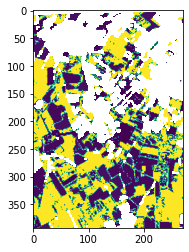

In [50]:
ds_xr = rasterio.open("./data/test_klein_gebied/openEO.tif").read(1)
plt.imshow(ds_xr)
plt.show()